<a href="https://colab.research.google.com/github/Akhilesh-K-Yadav/NMA-22-DL-Saltenas-Project/blob/main/Trials/Saltenas_XGBoost_GradBoost_trails.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from IPython.display import display
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

import numpy as np


from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [3]:

from google.colab import data_table
data_table.enable_dataframe_formatter()

In [2]:
#Code to get the dataset file from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dir = '/content/drive/MyDrive/'
all_data = pd.read_pickle(dir + 'allen_mice_VIP_N5.pkl')

In [12]:
#all_data.to_pickle('/content/drive/MyDrive/allen_mice_VIP_N5.pkl')

In [6]:
#del all_data

In [4]:
# @title Plotting functions

def imshow(img):
  """
  Helper function to plot unnormalised image

  Args:
    img: torch.tensor
      Image to be displayed

  Returns:
    Nothing
  """
  img = img / 2 + 0.5     # Unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.axis(False)
  plt.show()


def plot_function_approximation(x, relu_acts, y_hat):
  """
  Helper function to plot ReLU activations and
  function approximations

  Args:
    x: torch.tensor
      Incoming Data
    relu_acts: torch.tensor
      Computed ReLU activations for each point along the x axis (x)
    y_hat: torch.tensor
      Estimated labels/class predictions
      Weighted sum of ReLU activations for every point along x axis

  Returns:
    Nothing
  """
  fig, axes = plt.subplots(2, 1)

  # Plot ReLU Activations
  axes[0].plot(x, relu_acts.T);
  axes[0].set(xlabel='x',
              ylabel='Activation',
              title='ReLU Activations - Basis Functions')
  labels = [f"ReLU {i + 1}" for i in range(relu_acts.shape[0])]
  axes[0].legend(labels, ncol = 2)

  # Plot Function Approximation
  axes[1].plot(x, torch.sin(x), label='truth')
  axes[1].plot(x, y_hat, label='estimated')
  axes[1].legend()
  axes[1].set(xlabel='x',
              ylabel='y(x)',
              title='Function Approximation')

  plt.tight_layout()
  plt.show()

In [5]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.
# NOTE: This is mostly a GPU free tutorial.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

In [20]:
all_data.isnull().sum()

cell_specimen_id             0
stimulus_presentations_id    0
dff                          0
image_name                   0
is_change                    0
omitted                      0
dff_bc                       0
trace                        0
ophys_experiment_id          0
ophys_session_id             0
targeted_structure           0
imaging_depth                0
cre_line                     0
mouse_id                     0
sex                          0
session_number               0
exposure_level               0
dtype: int64

In [6]:
#Dataset preprocessing
all_data = all_data.query('exposure_level=="familiar"')
all_data = all_data.query('image_name!="omitted"')
all_data = all_data.query('is_change==False')

#all_data = all_data.groupby(['mouse_id','stimulus_presentations_id','cell_specimen_id','image_name'])['dff_bc'].mean().reset_index()
all_data2 = all_data.pivot(index=['mouse_id','stimulus_presentations_id','ophys_session_id','image_name'],columns='cell_specimen_id',values='dff_bc')
all_data = all_data2.fillna(0)
del all_data2

In [7]:
#More preprocessing
f1 = all_data.to_numpy()
randsel = np.random.choice(f1.shape[0],int(f1.shape[0]))
train_input = f1[randsel[:int(.9*f1.shape[0])],:]
test_input = f1[randsel[int(.9*f1.shape[0]):],:]

unique_label_name, train_labels_nums = np.unique(all_data.reset_index().image_name.values,return_inverse='true')
train_labels = np.identity(unique_label_name.shape[0])[train_labels_nums[randsel[:int(.9*f1.shape[0])]],]
_, test_labels_nums = np.unique(all_data.reset_index().image_name.values,return_inverse='true')
test_labels = np.identity(unique_label_name.shape[0])[test_labels_nums[randsel[int(.9*f1.shape[0]):]],]


In [8]:
#1D labels for the linear models, not for the NNs
T_labels = train_labels_nums[randsel[:int(.9*f1.shape[0])]]
t_labels = test_labels_nums[randsel[int(.9*f1.shape[0]):]]

In [29]:
print(T_labels.shape)
print(t_labels.shape)

(74634,)
(8293,)


In [9]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier

In [10]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import xgboost as xgb

In [13]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(train_input, T_labels)

XGBClassifier(objective='multi:softprob')

In [21]:
xgb_model.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'multi:softprob',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [14]:
preds = xgb_model.predict(test_input)

0.239961413240082


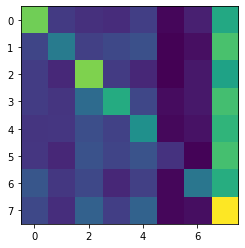

In [16]:
correct_xgb = ((preds == t_labels).sum().item())/len(t_labels)
print(correct_xgb)
confmat_xgb = confusion_matrix(t_labels, preds)
plt.figure()
plt.imshow(confmat_xgb)

In [17]:
model_GB = GradientBoostingClassifier()
model_GB.fit(train_input, T_labels)

GradientBoostingClassifier()

In [22]:
model_GB.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

0.2591342095743398


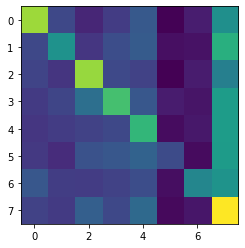

In [18]:
preds_GB = model_GB.predict(test_input)
correct_gb = ((preds_GB == t_labels).sum().item())/len(t_labels)
print(correct_gb)
confmat_gb = confusion_matrix(t_labels, preds_GB)
plt.figure()
plt.imshow(confmat_gb)

In [38]:
#The NN arch. Please modify it according to your need.
class NetDropout(nn.Module):
  """
  Network Class - 2D with the following structure:
  nn.Linear(1, 300) + leaky_relu(self.dropout1(self.fc1(x))) # First fully connected layer with 0.4 dropout
  nn.Linear(300, 500) + leaky_relu(self.dropout2(self.fc2(x))) # Second fully connected layer with 0.2 dropout
  nn.Linear(500, 1) # Final fully connected layer
  """

  def __init__(self,input_feature_num):
    """
    Initialize parameters of NetDropout

    Args:
      None

    Returns:
      Nothing
    """
    super(NetDropout, self).__init__()

    self.fc1 = nn.Linear(input_feature_num, 500)
    self.fc2 = nn.Linear(500, 700)
    self.fc3 = nn.Linear(700, 900)
    self.fc4 = nn.Linear(900, 900)
    self.fc5 = nn.Linear(900, 600)
    self.fc6 = nn.Linear(600, 300)
    self.fc7 = nn.Linear(300, 8)
    # We add two dropout layers
    self.dropout1 = nn.Dropout(0.4)
    self.dropout2 = nn.Dropout(0.2)

  def forward(self, x):
    """
    Forward pass of NetDropout

    Args:
      x: torch.tensor
        Input features

    Returns:
      output: torch.tensor
        Output/Predictions
    """
    x = F.leaky_relu(self.dropout1(self.fc1(x)))
    x = F.leaky_relu(self.dropout1(self.fc2(x)))
    x = F.leaky_relu(self.dropout1(self.fc3(x)))
    x = F.leaky_relu(self.dropout1(self.fc4(x)))
    x = F.leaky_relu(self.dropout1(self.fc5(x)))
    x = F.leaky_relu(self.dropout2(self.fc6(x)))
    output = self.fc7(x)
    return output

  0%|          | 0/2000 [00:00<?, ?it/s]

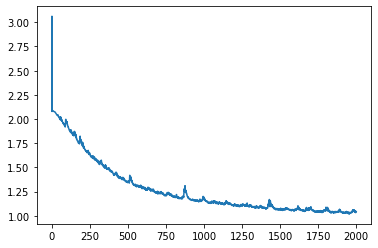

In [41]:
device = 'cuda'
net = NetDropout(train_input.shape[1]).to(device)
optimizer = optim.Adam(net.parameters(),weight_decay=1e-5, lr=1e-2)
criterion = nn.CrossEntropyLoss()

train_input = torch.Tensor(train_input).to(device)
labels = torch.Tensor(train_labels).to(device)
test_input = torch.Tensor(test_input).to(device)
training_losses = []
N_epochs = 2000

# Train it
net.to(device)
net.train()

for i in tqdm(range(N_epochs)):

  optimizer.zero_grad()
  outputs = net(train_input)
  loss = criterion(outputs,labels)
  loss.backward()
  optimizer.step()

  

  training_losses += [loss.item()]

net.eval()

plt.plot(training_losses)


Testing: 0.513083323284698
Training: 0.8045853996774243


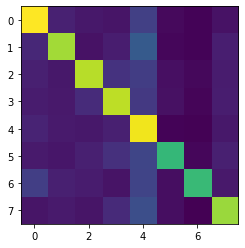

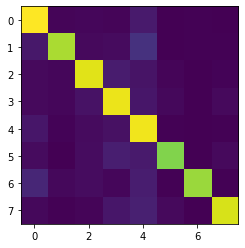

In [42]:
# testing full time course

#testing
outputs = net(test_input).to('cpu')
_, predictedlabels = torch.max(outputs, 1)
_, truelabels = torch.max(torch.tensor(test_labels),1)

outputs_train = net(train_input).to('cpu')
_, predictedlabels_train = torch.max(outputs_train, 1)
_, truelabels_train = torch.max(torch.tensor(train_labels),1)


correct = ((predictedlabels == truelabels).sum().item())/len(truelabels)
correct_train = ((predictedlabels_train == truelabels_train).sum().item())/len(truelabels_train)

confmat = confusion_matrix(truelabels, predictedlabels)

confmat_train = confusion_matrix(truelabels_train, predictedlabels_train)
plt.imshow(confmat, label='Testing')
#print(confmat)
print(f"Testing: {correct}")
print(f"Training: {correct_train}")
plt.figure()
plt.imshow(confmat_train, label='Training')